<a href="https://colab.research.google.com/github/AgarwalMayank2/Face_Detection/blob/main/applying_ML_algorithms/KNN_PRMLproj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# KNN Model

In [3]:
import numpy as np
import math

In [4]:
def euclidean_dist(x,y):
  # x1,y1,z1=x
  # x2,y2,z2=y
  return math.sqrt(sum([(a-b)**2 for a,b in zip(x,y)]))

In [5]:
from collections import Counter

In [63]:
def knn(k, X_train, X_test, y_test):
  predictions=[]
  for i in range(X_test.shape[0]):
    distances=[]
    nearest_labels=[]
    for j in range(X_train.shape[0]):
      # append the pair (distance, index) to distances
      dist=euclidean_dist(X_test[i], X_train[j])
      distances.append((dist, j))
    # sorting distances on the basis of first item of pair i.e. distance
    distances.sort(key=lambda x:x[0])
    for k1 in range(min(k, len(distances))):  # Ensure k does not exceed available distances
      nearest_labels.append(y_train[distances[k1][1]])

    label_counts = Counter(nearest_labels)
    most_common_label = label_counts.most_common(1)[0][0] if nearest_labels else -1

    predictions.append(label_encoder.inverse_transform([most_common_label])[0])

    if (i<=100 and i%10==0) or i==200:
      print(f'Label {i} detected : {predictions[i]}')

  accuracy = findAccuracy(predictions, y_test)
  return predictions, accuracy

In [64]:
def findAccuracy(predictions, y_test):
  count=0
  print(predictions)
  # print(y_test)
  for i in range(len(predictions)):
    if predictions[i]==label_encoder.inverse_transform([y_test[i]])[0]:
      count+=1

  accuracy = count/len(predictions)
  return accuracy*100

# Reading and Filtering Filtered CNN features

In [8]:
url_filtered_CNN_features_dataset = 'https://raw.githubusercontent.com/AgarwalMayank2/Face_Detection/refs/heads/main/processed_dataset/filtered_CNN_features_dataset.csv' #for CNN limited
df = pd.read_csv(url_filtered_CNN_features_dataset) # reading url for extracted CNN_features_dataset_limited.csv
df.shape

(4324, 2050)

In [9]:
label_counts = df['2048'].value_counts()
valid_labels = label_counts[label_counts >= 80].index
filtered_df_cnn = df[df['2048'].isin(valid_labels)]
filtered_df_cnn.drop('Unnamed: 0', axis=1, inplace=True)
filtered_df_cnn.head()

<ipython-input-9-ee670fc6a4bf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cnn.drop('Unnamed: 0', axis=1, inplace=True)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
207,0.334396,1.031447,0.751403,0.061664,1.358539,0.131194,2.189165,0.168872,0.077561,0.128026,0.183989,0.538582,0.101362,1.070623,1.274965,0.787965,1.010745,0.132910,0.028314,0.232709,0.125170,0.105015,0.464956,0.589406,0.245979,0.153097,0.682273,0.122172,0.666718,0.247453,0.008064,0.236150,0.472303,0.800596,0.308289,0.239711,0.476891,0.304502,0.680071,0.037881,0.757090,0.265668,0.062931,0.220174,0.270265,0.331900,0.522528,0.491509,0.038696,1.318256,...,0.112970,0.056320,0.082865,0.028923,0.209435,0.269742,0.005409,0.408730,0.123543,0.327678,1.284034,0.853707,0.804634,1.210236,0.327396,0.373742,0.089335,0.367123,0.925686,4.466197,0.013423,0.135680,0.016924,0.244878,0.039128,0.109210,0.607092,0.891468,0.262277,0.172887,0.159232,0.100507,0.027761,0.074810,0.167721,0.441469,0.068923,0.259991,0.056991,0.383078,0.238129,0.033446,0.691363,1.453779,0.023197,1.180975,0.147620,0.132144,0.061259,Donald_Rumsfeld
208,0.052159,1.385429,0.948584,0.242452,0.765526,0.205163,2.773744,0.487321,0.375770,0.297134,0.254478,0.268817,0.226023,0.755306,1.571226,0.634896,0.817997,0.279519,0.030687,0.638580,0.174374,0.192283,0.085247,0.038912,0.096299,0.230478,1.051941,0.557886,0.487828,0.096042,0.013753,0.253503,0.575466,0.742829,0.895683,0.090171,0.859928,0.090771,0.406033,0.007923,0.734094,0.281045,0.079760,0.306069,0.139493,0.093931,0.173692,0.798374,0.122333,0.540524,...,0.045386,0.086372,0.488368,0.045875,0.103680,0.922695,0.170794,0.367679,0.065409,0.188405,0.422431,1.099042,0.659823,1.011939,0.216857,0.493250,0.097184,0.119635,0.462243,2.912949,0.236338,0.237484,0.141670,0.035104,0.284068,0.123931,0.417244,0.408527,0.257193,0.160546,0.292699,0.385621,0.485847,0.118369,0.537141,0.401974,0.234668,0.328464,0.012105,0.509841,0.151970,0.030394,0.931749,1.507545,0.074761,1.410434,0.187171,0.037343,0.192220,Donald_Rumsfeld
209,0.215924,1.243201,1.040831,0.082872,0.996569,0.093324,3.699462,0.166822,0.085976,0.420676,0.743072,0.594263,0.322835,0.709497,1.102945,0.320867,0.884347,0.566730,0.000000,0.289763,0.127146,0.087026,0.343736,0.235992,0.022421,0.324048,0.569728,0.145811,1.424425,0.256161,0.058473,0.704165,0.387318,0.732642,0.286128,0.588900,0.114140,0.491552,0.665335,0.043467,0.519100,1.306838,0.157735,0.139541,0.202527,0.586414,0.195795,1.026655,0.029231,1.132063,...,0.091276,0.104907,0.461138,0.281048,0.192890,0.213128,0.099762,0.345900,0.447771,0.189232,1.449099,0.357289,0.778549,2.066705,0.517479,0.227441,0.147518,0.255494,1.600174,3.875662,0.007723,0.066497,0.231190,0.465194,0.154737,0.076969,1.172616,0.964553,0.397674,0.171304,0.182417,0.955412,0.343841,0.146380,0.652763,2.213488,0.377401,0.239819,0.121612,0.207383,0.280522,0.046874,0.933633,1.932075,0.076832,1.779623,0.345520,0.009288,0.176782,Donald_Rumsfeld
210,0.273529,1.568788,1.131568,0.069734,1.060217,0.003534,3.313872,0.470634,0.280771,0.550614,0.262875,0.203978,0.048359,0.683967,1.463157,0.409798,0.093417,0.014698,0.007150,0.033282,0.343952,0.047161,0.375896,0.512190,0.050570,0.142738,0.438233,0.136246,0.490448,0.306854,0.073924,0.337281,0.558025,0.466077,0.365227,0.380679,0.501479,0.459256,0.593401,0.165174,0.578679,0.190065,0.084886,0.027726,0.094829,0.125089,0.542136,0.634845,0.105904,1.298495,...,0.104201,0.047140,0.356027,0.056475,0.413982,0.104343,0.099540,0.150833,0.175534,0.201969,1.577922,0.516723,0.885130,0.936657,0.417312,0.317837,0.043798,0.405229,1.113544,4.088609,0.000829,0.175648,0.122848,0.101090,0.030845,0.169748,0.373309,0.369156,0.120333,0.111474,0.022102,0.631690,0.022785,0.033291,0.589543,0.904901,0.076007,0.020517,0.040802,0.564273,0.392776,0.303419,0.718607,1.815761,0.0342

## Train/Test split - for CNN dataset

In [10]:
# Separate features and labels
X_cnn = filtered_df_cnn.iloc[:, :-1]
y_cnn = filtered_df_cnn.iloc[:, -1]

# Encode labels (alphabetically)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_cnn)
# encoding is benificial as working on numbers is lot easier than working on string

# Ensure stratified split (16 training, 4 testing per class)
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_encoded, test_size=1/5, random_state=42, stratify=y_encoded)

# Normalize features
scaler = StandardScaler()
X_train_cnn = scaler.fit_transform(X_train_cnn)
X_test_cnn = scaler.transform(X_test_cnn)

print(f"Dataset size: {filtered_df_cnn.shape}")
print(f"Training size: {X_train_cnn.shape}, Testing size: {X_test_cnn.shape}")

Dataset size: (1140, 2049)
Training size: (912, 2048), Testing size: (228, 2048)


## Dimensionality reduction

In [11]:
from sklearn.decomposition import PCA

### Applying PCA on CNN features

In [12]:
pca=PCA(n_components=900)

X_train_cnn_pca=pca.fit_transform(X_train_cnn)
X_test_cnn_pca=pca.transform(X_test_cnn)

print(X_train_cnn_pca.shape)
print(X_test_cnn_pca.shape)

(912, 900)
(228, 900)


In [13]:
import numpy as np
print(np.sum(pca.explained_variance_ratio_))  # Should be close to 1

0.9999248390743487


### Applying LDA on CNN features

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Apply LDA with at most (number of classes - 1) components
lda = LDA(n_components=min(500, len(set(y_train_cnn)) - 1))

X_train_cnn_lda = lda.fit_transform(X_train_cnn, y_train_cnn)
X_test_cnn_lda = lda.transform(X_test_cnn)

print(X_train_cnn_lda.shape)
print(X_test_cnn_lda.shape)

(912, 4)
(228, 4)


## Setting y_train and y_test

In [14]:
y_train = y_train_cnn
y_test = y_test_cnn

print(y_train[:10])
print(y_test[:10])

[2 0 1 1 2 2 2 0 2 2]
[2 4 2 1 2 3 2 0 4 2]


## Printing y_test

In [25]:
for i in range(len(y_test_cnn)):
  if i<=100:
    print(label_encoder.inverse_transform([y_test[i]])[0])

George_W_Bush
Tony_Blair
George_W_Bush
Donald_Rumsfeld
George_W_Bush
Gerhard_Schroeder
George_W_Bush
Colin_Powell
Tony_Blair
George_W_Bush
Colin_Powell
Colin_Powell
Gerhard_Schroeder
George_W_Bush
Donald_Rumsfeld
Tony_Blair
George_W_Bush
Colin_Powell
Colin_Powell
George_W_Bush
George_W_Bush
Colin_Powell
George_W_Bush
Colin_Powell
Donald_Rumsfeld
Colin_Powell
George_W_Bush
George_W_Bush
Colin_Powell
George_W_Bush
George_W_Bush
Colin_Powell
George_W_Bush
Tony_Blair
Donald_Rumsfeld
Donald_Rumsfeld
Tony_Blair
George_W_Bush
Tony_Blair
George_W_Bush
Gerhard_Schroeder
Donald_Rumsfeld
Colin_Powell
Gerhard_Schroeder
George_W_Bush
Tony_Blair
Gerhard_Schroeder
Donald_Rumsfeld
Donald_Rumsfeld
George_W_Bush
George_W_Bush
George_W_Bush
Gerhard_Schroeder
Colin_Powell
George_W_Bush
George_W_Bush
Gerhard_Schroeder
Colin_Powell
George_W_Bush
Colin_Powell
Tony_Blair
George_W_Bush
Tony_Blair
George_W_Bush
Tony_Blair
George_W_Bush
Colin_Powell
George_W_Bush
George_W_Bush
Donald_Rumsfeld
Donald_Rumsfeld
Geo

# Reading and Filtering Filtered LBP features

In [26]:
url_filtered_lbp_features = 'https://raw.githubusercontent.com/AgarwalMayank2/Face_Detection/refs/heads/main/processed_dataset/filtered_LBP_features_dataset.csv'
df = pd.read_csv(url_filtered_lbp_features)

In [27]:
label_counts = df['256'].value_counts()
valid_labels = label_counts[label_counts >= 80].index
filtered_df_LBP = df[df['256'].isin(valid_labels)]
filtered_df_LBP.drop('Unnamed: 0', axis=1, inplace=True)
print(filtered_df_LBP.head())

         0     1      2      3     4     5  ...    251    252    253    254      255            256
199  747.0  72.0  433.0  185.0  61.0   6.0  ...  578.0  616.0  546.0  453.0  12702.0  George_W_Bush
200  516.0  33.0  438.0  186.0  34.0   2.0  ...  354.0  500.0  426.0  516.0  17530.0  George_W_Bush
201  805.0  76.0  366.0  204.0  68.0  10.0  ...  413.0  581.0  438.0  537.0  22703.0  George_W_Bush
202  572.0  42.0  304.0  219.0  37.0   3.0  ...  273.0  590.0  465.0  315.0   3466.0  George_W_Bush
203  577.0  49.0  403.0  268.0  87.0   4.0  ...  284.0  500.0  448.0  280.0   4402.0  George_W_Bush

[5 rows x 257 columns]


<ipython-input-27-d44b37404344>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_LBP.drop('Unnamed: 0', axis=1, inplace=True)


## Train/Test split - for LBP dataset

In [28]:
# Separate features and labels
X_LBP = filtered_df_LBP.iloc[:, :-1]
y_LBP = filtered_df_LBP.iloc[:, -1]

# Encode labels (alphabetically)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_LBP)
# encoding is benificial as working on numbers is lot easier than working on string

# Ensure stratified split (64 training, 16 testing per class)
X_train_LBP, X_test_LBP, y_train_LBP, y_test_LBP = train_test_split(X_LBP, y_encoded, test_size=1/5, random_state=42, stratify=y_encoded)

# Normalize features
scaler = StandardScaler()
X_train_LBP = scaler.fit_transform(X_train_LBP)
X_test_LBP = scaler.transform(X_test_LBP)

print(f"Dataset size: {filtered_df_LBP.shape}")
print(f"Training size: {X_train_LBP.shape}, Testing size: {X_test_LBP.shape}")

Dataset size: (1140, 257)
Training size: (912, 256), Testing size: (228, 256)


## Dimensionality Reduction

### Applying PCA on LBP features

In [33]:
pca=PCA(n_components=150)

X_train_LBP_pca=pca.fit_transform(X_train_LBP)
X_test_LBP_pca=pca.transform(X_test_LBP)

print(X_train_LBP_pca.shape)
print(X_test_LBP_pca.shape)

(912, 150)
(228, 150)


In [34]:
import numpy as np
print(np.sum(pca.explained_variance_ratio_))  # Should be close to 1

0.9510735214976049


### Applying LDA on LBP features

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Apply LDA with at most (number of classes - 1) components
lda = LDA(n_components=min(500, len(set(y_train_LBP)) - 1))

X_train_LBP_lda = lda.fit_transform(X_train_LBP, y_train_LBP)
X_test_LBP_lda = lda.transform(X_test_LBP)

print(X_train_LBP_lda.shape)
print(X_test_LBP_lda.shape)

(912, 4)
(228, 4)


## Setting y_train and y_test

In [36]:
y_train = y_train_LBP
y_test = y_test_LBP

print(y_train[:10])
print(y_test[:10])

[2 0 1 1 2 2 2 0 2 2]
[2 4 2 1 2 3 2 0 4 2]


## Printing y_test for checking

In [38]:
for i in range(len(y_test_LBP)):
  if i<=100:
    print(label_encoder.inverse_transform([y_test[i]])[0])

George_W_Bush
Tony_Blair
George_W_Bush
Donald_Rumsfeld
George_W_Bush
Gerhard_Schroeder
George_W_Bush
Colin_Powell
Tony_Blair
George_W_Bush
Colin_Powell
Colin_Powell
Gerhard_Schroeder
George_W_Bush
Donald_Rumsfeld
Tony_Blair
George_W_Bush
Colin_Powell
Colin_Powell
George_W_Bush
George_W_Bush
Colin_Powell
George_W_Bush
Colin_Powell
Donald_Rumsfeld
Colin_Powell
George_W_Bush
George_W_Bush
Colin_Powell
George_W_Bush
George_W_Bush
Colin_Powell
George_W_Bush
Tony_Blair
Donald_Rumsfeld
Donald_Rumsfeld
Tony_Blair
George_W_Bush
Tony_Blair
George_W_Bush
Gerhard_Schroeder
Donald_Rumsfeld
Colin_Powell
Gerhard_Schroeder
George_W_Bush
Tony_Blair
Gerhard_Schroeder
Donald_Rumsfeld
Donald_Rumsfeld
George_W_Bush
George_W_Bush
George_W_Bush
Gerhard_Schroeder
Colin_Powell
George_W_Bush
George_W_Bush
Gerhard_Schroeder
Colin_Powell
George_W_Bush
Colin_Powell
Tony_Blair
George_W_Bush
Tony_Blair
George_W_Bush
Tony_Blair
George_W_Bush
Colin_Powell
George_W_Bush
George_W_Bush
Donald_Rumsfeld
Donald_Rumsfeld
Geo

# Calling KNN function on CNN and LBP features (without Dimensionality Reduction)

In [56]:
y_pred, acc = knn(5, X_train_cnn, X_test_cnn, y_test)
print("Predictions : ", y_pred)
print("Accuracy : ", acc, " %")

Label 0 detected : George_W_Bush
Label 1 detected : George_W_Bush
Label 2 detected : George_W_Bush
Label 3 detected : Donald_Rumsfeld
Label 4 detected : George_W_Bush
Label 5 detected : Donald_Rumsfeld
Label 6 detected : George_W_Bush
Label 7 detected : Colin_Powell
Label 8 detected : Tony_Blair
Label 9 detected : George_W_Bush
Label 10 detected : Tony_Blair
Label 11 detected : Donald_Rumsfeld
Label 12 detected : Gerhard_Schroeder
Label 13 detected : George_W_Bush
Label 14 detected : George_W_Bush
Label 15 detected : Tony_Blair
Label 16 detected : George_W_Bush
Label 17 detected : Colin_Powell
Label 18 detected : George_W_Bush
Label 19 detected : George_W_Bush
Label 20 detected : George_W_Bush
Label 21 detected : George_W_Bush
Label 22 detected : George_W_Bush
Label 23 detected : Colin_Powell
Label 24 detected : George_W_Bush
Label 25 detected : Colin_Powell
Label 26 detected : George_W_Bush
Label 27 detected : George_W_Bush
Label 28 detected : George_W_Bush
Label 29 detected : George_

In [39]:
y_pred, acc = knn(5, X_train_LBP, X_test_LBP, y_test)
print("Predictions : ", y_pred)
print("Accuracy : ", acc, " %")

# Calling KNN function on CNN and LBP features (with Dimensionality Reduction)

## PCA on CNN and LBP features

In [ ]:
y_pred, acc = knn(5, X_train_cnn_pca, X_test_cnn_pca, y_test)
print("Predictions : ", y_pred)
print("Accuracy : ", acc, " %")

In [ ]:
y_pred, acc = knn(5, X_train_LBP_pca, X_test_LBP_pca, y_test)
print("Predictions : ", y_pred)
print("Accuracy : ", acc, " %")

## LDA on CNN and LBP features

In [ ]:
y_pred, acc = knn(5, X_train_cnn_lda, X_test_cnn_lda, y_test)
print("Predictions : ", y_pred)
print("Accuracy : ", acc, " %")

In [ ]:
y_pred, acc = knn(5, X_train_LBP_lda, X_test_LBP_lda, y_test)
print("Predictions : ", y_pred)
print("Accuracy : ", acc, " %")

# Combining CNN and LBP features (Concatenating)

In [42]:
combined_X_train = np.concatenate((X_train_cnn, X_train_LBP), axis=1)
combined_X_test = np.concatenate((X_test_cnn, X_test_LBP), axis=1)

In [44]:
print("No. of CNN features + No. of LBP features = ", X_train_cnn.shape[1] + X_train_LBP.shape[1])
print("Total no. of features after concatenation = ", combined_X_train.shape[1])

No. of CNN features + No. of LBP features =  2304
Total no. of features after concatenation =  2304


In [45]:
print(combined_X_train.shape[1])
print(combined_X_test.shape[1])

2304
2304


## Applying PCA on Combined features

In [46]:
pca=PCA(n_components=500)

X_train_pca=pca.fit_transform(combined_X_train)
X_test_pca=pca.transform(combined_X_test)

print(X_train_pca.shape)
print(X_test_pca.shape)

(912, 500)
(228, 500)


## Applying LDA on Combined features

In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Apply LDA with at most (number of classes - 1) components
lda = LDA(n_components=min(500, len(set(y_train)) - 1))

X_train_lda = lda.fit_transform(combined_X_train, y_train)
X_test_lda = lda.transform(combined_X_test)

print(X_train_lda.shape)
print(X_test_lda.shape)

(912, 4)
(228, 4)


# Calling KNN function on Combined features (without Dimensionality Reduction)

In [49]:
y_pred, acc = knn(5, combined_X_train, combined_X_test, y_test)
print("Predictions : ", y_pred)
print("Accuracy : ", acc, " %")

# Calling KNN function on Combined features (with Dimensionality Reduction)

## PCA on Combined features

In [62]:
y_pred, acc = knn(5, X_train_pca, X_test_pca, y_test)
print("Predictions : ", y_pred)
print("Accuracy : ", acc, " %")

Label 0 detected : George_W_Bush
Label 1 detected : George_W_Bush
Label 2 detected : George_W_Bush
Label 3 detected : Donald_Rumsfeld
Label 4 detected : George_W_Bush
Label 5 detected : Donald_Rumsfeld
Label 6 detected : George_W_Bush
Label 7 detected : George_W_Bush
Label 8 detected : Tony_Blair
Label 9 detected : George_W_Bush
Label 10 detected : Tony_Blair
Label 11 detected : Donald_Rumsfeld
Label 12 detected : Tony_Blair
Label 13 detected : Tony_Blair
Label 14 detected : George_W_Bush
Label 15 detected : Tony_Blair
Label 16 detected : Donald_Rumsfeld
Label 17 detected : Colin_Powell
Label 18 detected : George_W_Bush
Label 19 detected : George_W_Bush
Label 20 detected : George_W_Bush
Label 21 detected : George_W_Bush
Label 22 detected : George_W_Bush
Label 23 detected : Colin_Powell
Label 24 detected : George_W_Bush
Label 25 detected : Colin_Powell
Label 26 detected : Colin_Powell
Label 27 detected : Tony_Blair
Label 28 detected : George_W_Bush
Label 29 detected : George_W_Bush
Labe

## LDA on Combined features

In [65]:
y_pred, acc = knn(5, X_train_lda, X_test_lda, y_test)
print("Predictions : ", y_pred)
print("Accuracy : ", acc, " %")

Label 0 detected : George_W_Bush
Label 10 detected : Colin_Powell
Label 20 detected : George_W_Bush
Label 30 detected : George_W_Bush
Label 40 detected : Gerhard_Schroeder
Label 50 detected : George_W_Bush
Label 60 detected : Tony_Blair
Label 70 detected : George_W_Bush
Label 80 detected : George_W_Bush
Label 90 detected : Colin_Powell
Label 100 detected : Colin_Powell
Label 200 detected : Colin_Powell
['George_W_Bush', 'Tony_Blair', 'George_W_Bush', 'Donald_Rumsfeld', 'George_W_Bush', 'George_W_Bush', 'Gerhard_Schroeder', 'Colin_Powell', 'Tony_Blair', 'George_W_Bush', 'Colin_Powell', 'Colin_Powell', 'Gerhard_Schroeder', 'George_W_Bush', 'Donald_Rumsfeld', 'George_W_Bush', 'George_W_Bush', 'Tony_Blair', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'Donald_Rumsfeld', 'George_W_Bush', 'Colin_Powell', 'George_W_Bush', 'Colin_Powell', 'George_W_Bush', 'George_W_Bush', 'Gerhard_Schroeder', 'George_W_Bush', 'George_W_Bush', 'Colin_Powell', 'George_W_Bush', 'Tony_Blair', 'Donald_Rumsfel

# Visualization

## Apply LDA on Combined features to keep only 2 features

In [69]:
lda = LDA(n_components=2)

X_train_lda_graph = lda.fit_transform(combined_X_train, y_train)
X_test_lda_graph = lda.transform(combined_X_test)

print(X_train_lda_graph.shape)
print(X_test_lda_graph.shape)

(912, 2)
(228, 2)


In [70]:
y_pred, acc = knn(5, X_train_lda_graph, X_test_lda_graph, y_test)
print("Predictions : ", y_pred)
print("Accuracy : ", acc, " %")

Label 0 detected : George_W_Bush
Label 10 detected : Colin_Powell
Label 20 detected : George_W_Bush
Label 30 detected : Donald_Rumsfeld
Label 40 detected : Gerhard_Schroeder
Label 50 detected : George_W_Bush
Label 60 detected : George_W_Bush
Label 70 detected : George_W_Bush
Label 80 detected : George_W_Bush
Label 90 detected : Colin_Powell
Label 100 detected : Colin_Powell
Label 200 detected : Colin_Powell
['George_W_Bush', 'Gerhard_Schroeder', 'George_W_Bush', 'Gerhard_Schroeder', 'George_W_Bush', 'Tony_Blair', 'Donald_Rumsfeld', 'Colin_Powell', 'Tony_Blair', 'George_W_Bush', 'Colin_Powell', 'Colin_Powell', 'Colin_Powell', 'Gerhard_Schroeder', 'Donald_Rumsfeld', 'George_W_Bush', 'George_W_Bush', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'George_W_Bush', 'George_W_Bush', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'Donald_Rumsfeld', 'Colin_Powell', 'George_W_Bush', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'George_W_Bush', 'Donald_Rumsfeld', 'Colin_Powell', 'George_W_

In [66]:
# Actual labels
y_test_labels = label_encoder.inverse_transform(y_test)

In [73]:
print(np.unique(y_test_labels))

['Colin_Powell' 'Donald_Rumsfeld' 'George_W_Bush' 'Gerhard_Schroeder'
 'Tony_Blair']


### Graph visualisation

<ipython-input-90-310e31f358de>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(classes))


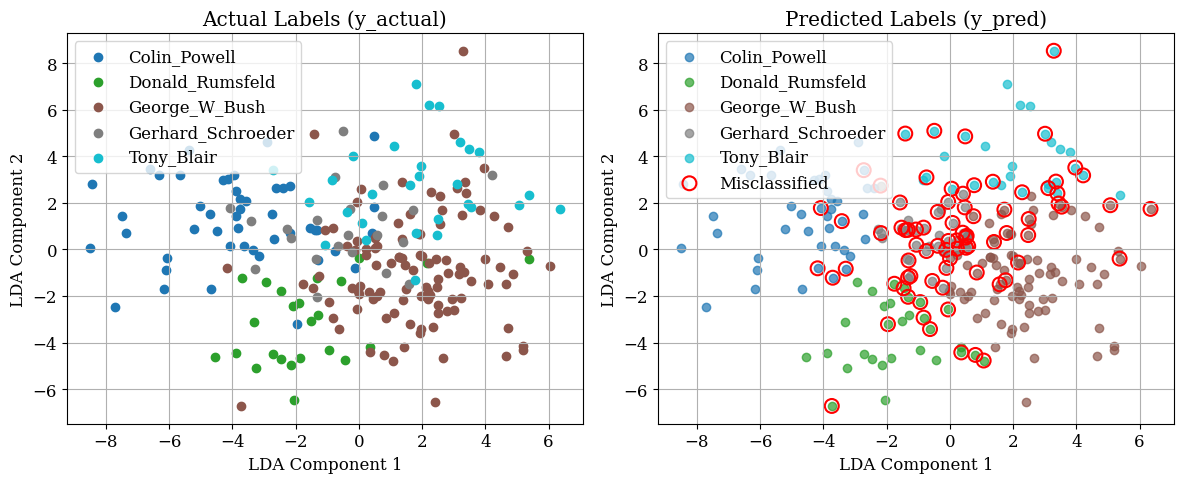

In [90]:
import matplotlib.pyplot as plt
import numpy as np

X_plot = X_test_lda_graph
y_actual = np.array(y_test_labels)
y_pred = np.array(y_pred)

classes = np.unique(y_actual)
colors = plt.cm.get_cmap('tab10', len(classes))

# Identify misclassified points
misclassified = y_actual != y_pred

# Create side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot y_actual ---
for i, label in enumerate(classes):
    indices = np.where(y_actual == label)
    axs[0].scatter(X_plot[indices, 0], X_plot[indices, 1], label=f'{label}', color=colors(i))
axs[0].set_title("Actual Labels (y_actual)")
axs[0].set_xlabel("LDA Component 1")
axs[0].set_ylabel("LDA Component 2")
axs[0].legend()
axs[0].grid(True)

# --- Plot y_pred ---
for i, label in enumerate(classes):
    indices = np.where(y_pred == label)
    axs[1].scatter(X_plot[indices, 0], X_plot[indices, 1], label=f'{label}', color=colors(i), alpha=0.7)

# Highlight misclassified points with red borders
axs[1].scatter(X_plot[misclassified, 0], X_plot[misclassified, 1],
               facecolors='none', edgecolors='red', s=100, linewidths=1.5, label='Misclassified')

axs[1].set_title("Predicted Labels (y_pred)")
axs[1].set_xlabel("LDA Component 1")
axs[1].set_ylabel("LDA Component 2")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### Confusion Matrices (One vs All)

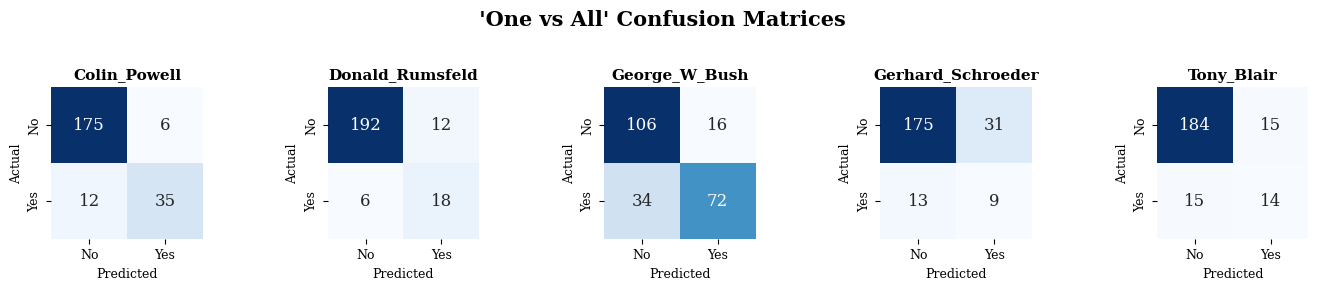

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Inputs
y_true = np.array(y_test_labels)
y_pred = np.array(y_pred)

classes = np.unique(y_true)
class_names = [f"{c}" for c in classes]  # or actual names

n_classes = len(classes)
cols = 5  # All in one row
rows = (n_classes + cols - 1) // cols

# Slightly bigger square plots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.8, rows * 2.8), squeeze=False)
fig.suptitle(" 'One vs All' Confusion Matrices", fontsize=15, fontweight='bold')

for i, cls in enumerate(classes):
    row, col = divmod(i, cols)
    ax = axes[row][col]

    binary_true = (y_true == cls).astype(int)
    binary_pred = (y_pred == cls).astype(int)
    cm = confusion_matrix(binary_true, binary_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                square=True, xticklabels=["No", "Yes"], yticklabels=["No", "Yes"],
                annot_kws={"size": 12})

    ax.set_title(class_names[i], fontsize=11, fontweight='semibold')
    ax.set_xlabel("Predicted", fontsize=9)
    ax.set_ylabel("Actual", fontsize=9)
    ax.tick_params(labelsize=9)

# Turn off extra axes
for j in range(i+1, rows*cols):
    row, col = divmod(j, cols)
    axes[row][col].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Use your LDA-reduced data
X_train_plot = X_train_lda_graph
X_test_plot = X_test_lda_graph

# Convert labels to integers for coloring
y_train_int = label_encoder.transform(y_train)

# Define mesh grid boundaries
x_min, x_max = X_train_plot[:, 0].min() - 1, X_train_plot[:, 0].max() + 1
y_min, y_max = X_train_plot[:, 1].min() - 1, X_train_plot[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))

# Predict over the entire mesh grid using your KNN function
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_preds = []

print("Generating decision boundary...")

for point in grid_points:
    # Use your custom KNN with just one test point at a time
    pred, _ = knn(5, X_train_plot, X_test=np.array([point]), y_test=[0])  # dummy y_test
    grid_preds.append(label_encoder.transform([pred[0]])[0])  # convert back to int

Z = np.array(grid_preds).reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 6))
cmap_light = ListedColormap(['#FFCCCC', '#CCFFCC', '#CCCCFF', '#FFFFCC', '#E0CCFF'])
cmap_bold = ListedColormap(['#FF0000', '#00CC00', '#0000FF', '#CCCC00', '#8000FF'])

plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)

# Plot training points
scatter = plt.scatter(X_train_plot[:, 0], X_train_plot[:, 1], c=y_train_int, cmap=cmap_bold, edgecolor='k', s=60)
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.title("KNN Decision Boundary (Custom KNN)")

# Legend
handles = scatter.legend_elements()[0]
labels = label_encoder.inverse_transform(np.unique(y_train_int))
plt.legend(handles, labels, title="Classes", loc="upper right")

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


ValueError: y contains previously unseen labels: 2